<a href="https://colab.research.google.com/github/yildizyakup/plant-disease-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Detection

In [55]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt
import glob
import imutils

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
train_images = [cv.imread(file,0) for file in glob.glob("/content/drive/MyDrive/Plant_Disease_Detection/Train/*.pgm")]

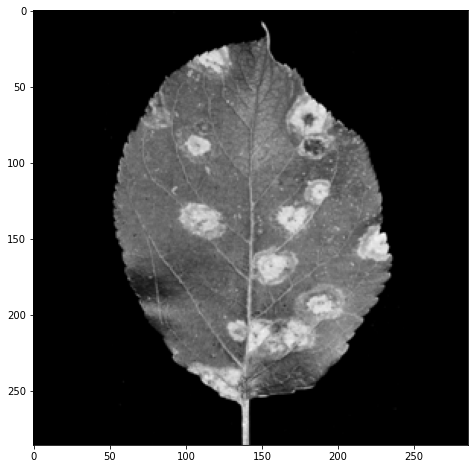

In [24]:
plt.figure(figsize = (13,8))    
plt.imshow(train_images[1],cmap = 'gray')
plt.show()

Detect when an image is Blurry:
https://www.youtube.com/watch?v=5YP7OoMhXbM

In [18]:
for i in range(len(train_images)):

    laplacian_var = cv.Laplacian(train_images[i],cv.CV_64F).var()
    print("Train image",i+1,":",laplacian_var)
    
    if laplacian_var < 5:
        print("Image is blurry")

Train image 1 : 1168.4074999982643
Train image 2 : 402.19566896145375
Train image 3 : 99.94311960931559
Train image 4 : 1066.6449350548799


In [19]:
# kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
# sharpened = cv.filter2D(train_images[0], -1, kernel)
# plt.figure(figsize = (13,8))    
# plt.imshow(sharpened,cmap = 'gray')
# plt.show()

HomomorphicFilter: https://github.com/glasgio/homomorphic-filter

In [20]:
import logging

# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """
    
    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) != 2:
            print(I.shape)
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) != 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

In [54]:
def is_contour_bad(c):
	# approximate the contour
	peri = cv.arcLength(c, True)
	approx = cv.approxPolyDP(c, 0.02 * peri, True)
	# the contour is 'bad' if it is not a rectangle
	return not len(approx) == 0

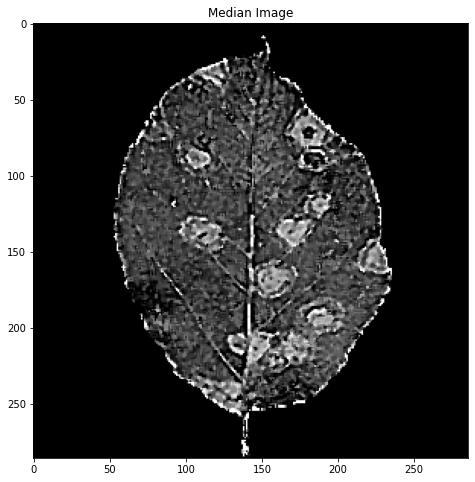

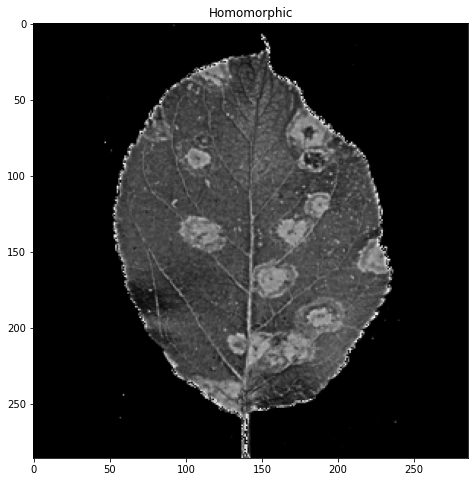

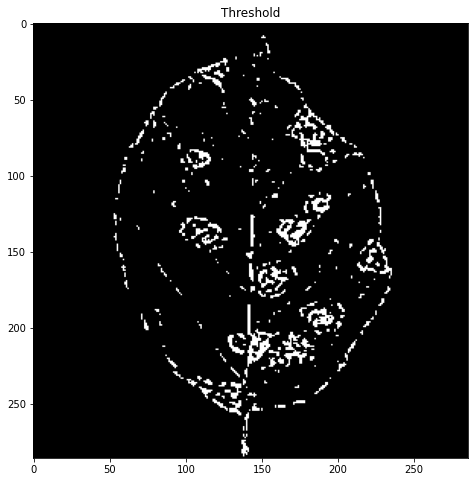

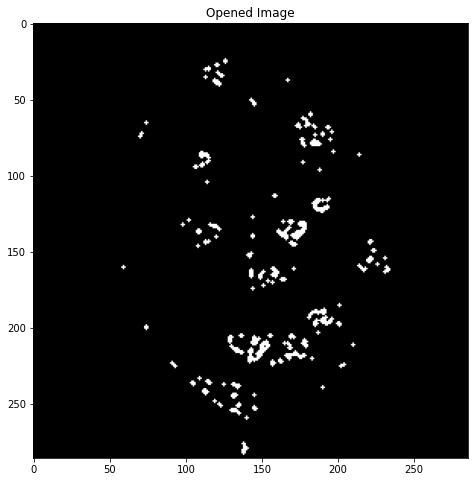

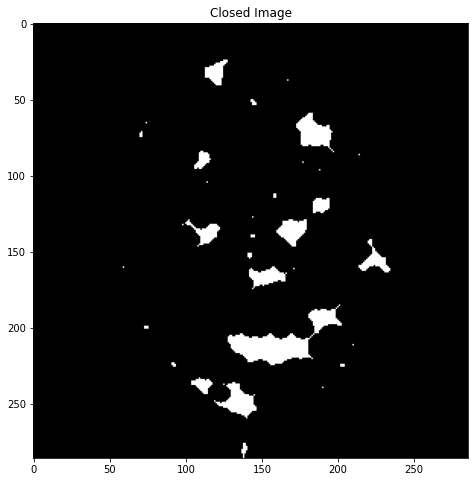

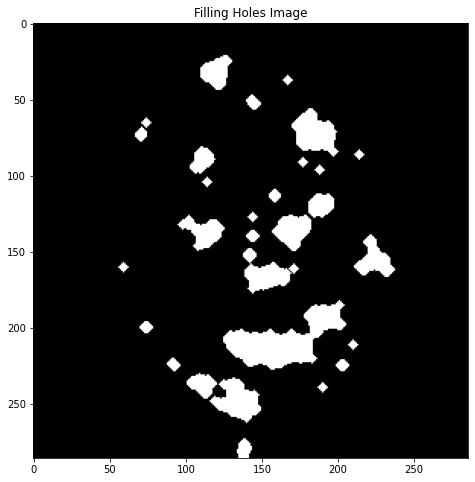

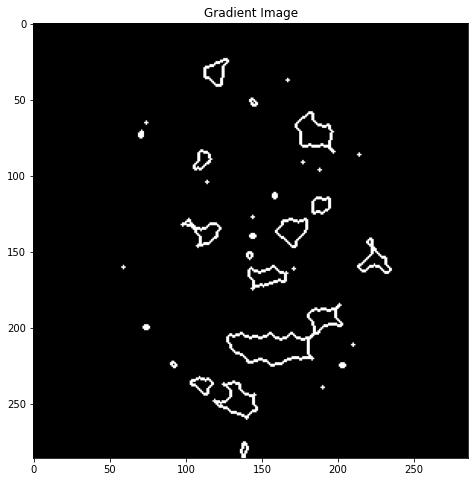

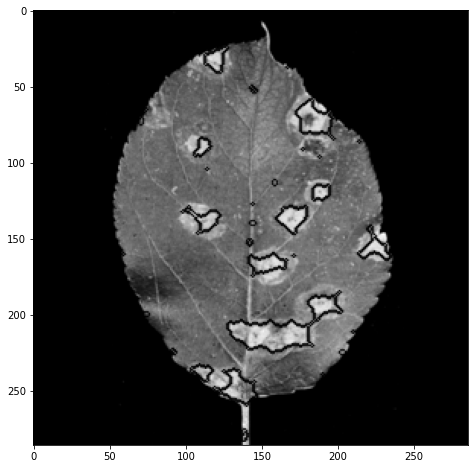

In [131]:
image_copy = train_images[1].copy()
laplacian_var = cv.Laplacian(image_copy,cv.CV_64F).var()
homo_filter = HomomorphicFilter(a = 0.96, b = 1)
homo_filtered = homo_filter.filter(I=image_copy, filter_params=[30,2])
if laplacian_var < 500:
  kernel = np.array([[-1,-1, -1], 
                    [-1, 9, -1],
                    [-1,-1, -1]])
else:
  kernel = np.array([[0,-1, 0], 
                    [-1,5,-1],
                    [0,-1, 0]])
sharpened = cv.filter2D(homo_filtered, -1, kernel)
median = cv.medianBlur(sharpened,3)

plt.figure(figsize = (13,8))   
plt.title("Median Image")
plt.imshow(median,cmap = 'gray')
plt.show()

#_,th = cv.threshold(median,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
_,th = cv.threshold(median,155,255,cv.THRESH_BINARY)
#th = cv.adaptiveThreshold(blur, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21,10)

plt.figure(figsize = (13,8))   
plt.title("Homomorphic")
plt.imshow(homo_filtered,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Threshold")
plt.imshow(th,cmap = 'gray')
plt.show()

kernel3x3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
kernel13x13 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(13,13))

erosion = cv.erode(th,kernel3x3, iterations = 1)
dilation = cv.dilate(th,kernel3x3,iterations = 1)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel3x3)
median = cv.medianBlur(opening,3)
closing = cv.morphologyEx(median, cv.MORPH_CLOSE, kernel13x13)
gradient = cv.morphologyEx(closing, cv.MORPH_GRADIENT, kernel3x3)
fillingholes = cv.dilate(closing,kernel3x3,iterations = 3)
contours, hierarchy = cv.findContours(image=gradient, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)
cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv.LINE_AA)



"""
plt.figure(figsize = (13,8))   
plt.title("Eroded Image")
plt.imshow(erosion,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Dilated Image")
plt.imshow(dilation,cmap = 'gray')
plt.show()
"""
plt.figure(figsize = (13,8))   
plt.title("Opened Image")
plt.imshow(opening,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Closed Image")
plt.imshow(closing,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Filling Holes Image")
plt.imshow(fillingholes,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Gradient Image")
plt.imshow(gradient,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))  
plt.imshow(image_copy,cmap = "gray")
plt.show()

In [111]:
def line_counter(src_img):
    canny_img = cv.Canny(src_img, 50, 200, None, 3)
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 10  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 1  # minimum number of pixels making up a line
    max_line_gap = 30 # maximum gap in pixels between connectable line segments
    #line_image = np.copy(img) * 0  # creating a blank to draw lines on
    line_image = np.zeros(src_img.shape, dtype="uint8")

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv.HoughLinesP(canny_img, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    if lines is not None:
        return len(lines)
    else:
        return 0

line_counter(homo_filtered)

297

[INFO] found 30 blobs
[INFO] label: 0 (background)
[INFO] label: 1 (foreground)
[INFO] label: 2 (foreground)
[INFO] label: 3 (foreground)
[INFO] label: 4 (foreground)
[INFO] label: 5 (foreground)
[INFO] label: 6 (foreground)
[INFO] label: 7 (foreground)
[INFO] label: 8 (foreground)
[INFO] label: 9 (foreground)
[INFO] label: 10 (foreground)
[INFO] label: 11 (foreground)
[INFO] label: 12 (foreground)
[INFO] label: 13 (foreground)
[INFO] label: 14 (foreground)
[INFO] label: 15 (foreground)
[INFO] label: 16 (foreground)
[INFO] label: 17 (foreground)
[INFO] label: 18 (foreground)
[INFO] label: 19 (foreground)
[INFO] label: 20 (foreground)
[INFO] label: 21 (foreground)
[INFO] label: 22 (foreground)
[INFO] label: 23 (foreground)
[INFO] label: 24 (foreground)
[INFO] label: 25 (foreground)
[INFO] label: 26 (foreground)
[INFO] label: 27 (foreground)
[INFO] label: 28 (foreground)
[INFO] label: 29 (foreground)


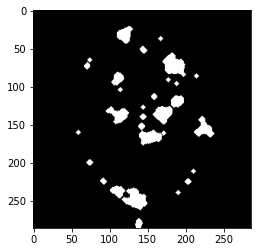

In [121]:
from skimage.filters import threshold_local
from skimage import measure
# perform connected components analysis on the thresholded images and initialize the
# mask to hold only the "large" components we are interested in
labels = measure.label(fillingholes,background=0)
mask = np.zeros(th.shape, dtype="uint8")
print("[INFO] found {} blobs".format(len(np.unique(labels))))
 
# loop over the unique components
for (i, label) in enumerate(np.unique(labels)):
    # if this is the background label, ignore it
    if label == 0:
        print("[INFO] label: 0 (background)")
        continue
 
    # otherwise, construct the label mask to display only connected components for
    # the current label
    print("[INFO] label: {} (foreground)".format(i))
    labelMask = np.zeros(th.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv.countNonZero(labelMask)
 
    # if the number of pixels in the component is sufficiently large, add it to our
    # mask of "large" blobs
    if numPixels > 8 and numPixels < 700:
        mask = cv.add(mask, labelMask)

plt.imshow(mask,cmap ="gray")